# Fit the spectrum of CTIO Data in November 2016
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : December 15th 2016

The goal is to extract the spectrum after the rotation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [2]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [3]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [4]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [5]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [6]:
%load_ext Cython

In [7]:
from IPython.display import Image, display

In [8]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [9]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [10]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [11]:
inputdir="./spectrum_fitsspec"
object_name='HD14943'

In [12]:
outputdir="./spectrum_calibspec"

In [13]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [12]:
input_filelist=os.listdir(inputdir) 

In [13]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [16]:
#print input_filelist

In [14]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [15]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    index=0

    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                index=index+1
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages

In [16]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # Make the list

In [17]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [18]:
print indexes_files

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117]


In [19]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [20]:
sorted_numbers=indexes_files[sorted_indexes]

In [21]:
print sorted_indexes

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116]


In [22]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [26]:
#sorted_files

## Build full filename
----------------------------

In [23]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [24]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [25]:
print sorted_filenames.shape

(117,)


## Acces to spectrum data
----------------------------------

In [26]:
all_dates = []
all_airmass = []
all_spectra = []
all_titles = []
all_header = []
all_img = []

In [27]:
%%cython

import numpy as np
from astropy.io import fits

def BuildRawSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    all_spectra = []
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        spectrum=hdu_list[0].data
        
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_spectra.append(spectrum)
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_spectra,all_titles,all_header,all_expo

In [29]:
all_dates,all_airmass,all_spectra,all_titles,all_header,all_expo=BuildRawSpec(sorted_files,sorted_numbers,object_name)

## Show Spectra
-----------------------

In [30]:
len(all_spectra)

117

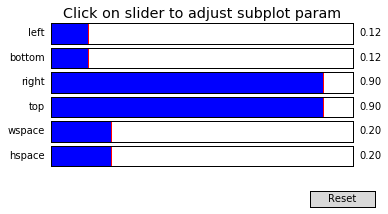

In [72]:
plt.subplot_tool() 

In [70]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
    
def ShowSpectra(all_spectra,all_titles,object_name):
    """
    ShowSpectra: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_spectra)
    MAXIMGROW=int(NBIMAGES/5)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(25,60))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        spectrum=all_spectra[index]
        axarr[iy,ix].plot(spectrum,'r-',lw=2)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].set_ylim(0.,200.)
        axarr[iy,ix].grid(True)
      
    #title='spectra'
    #plt.suptitle(title,size=16)
   

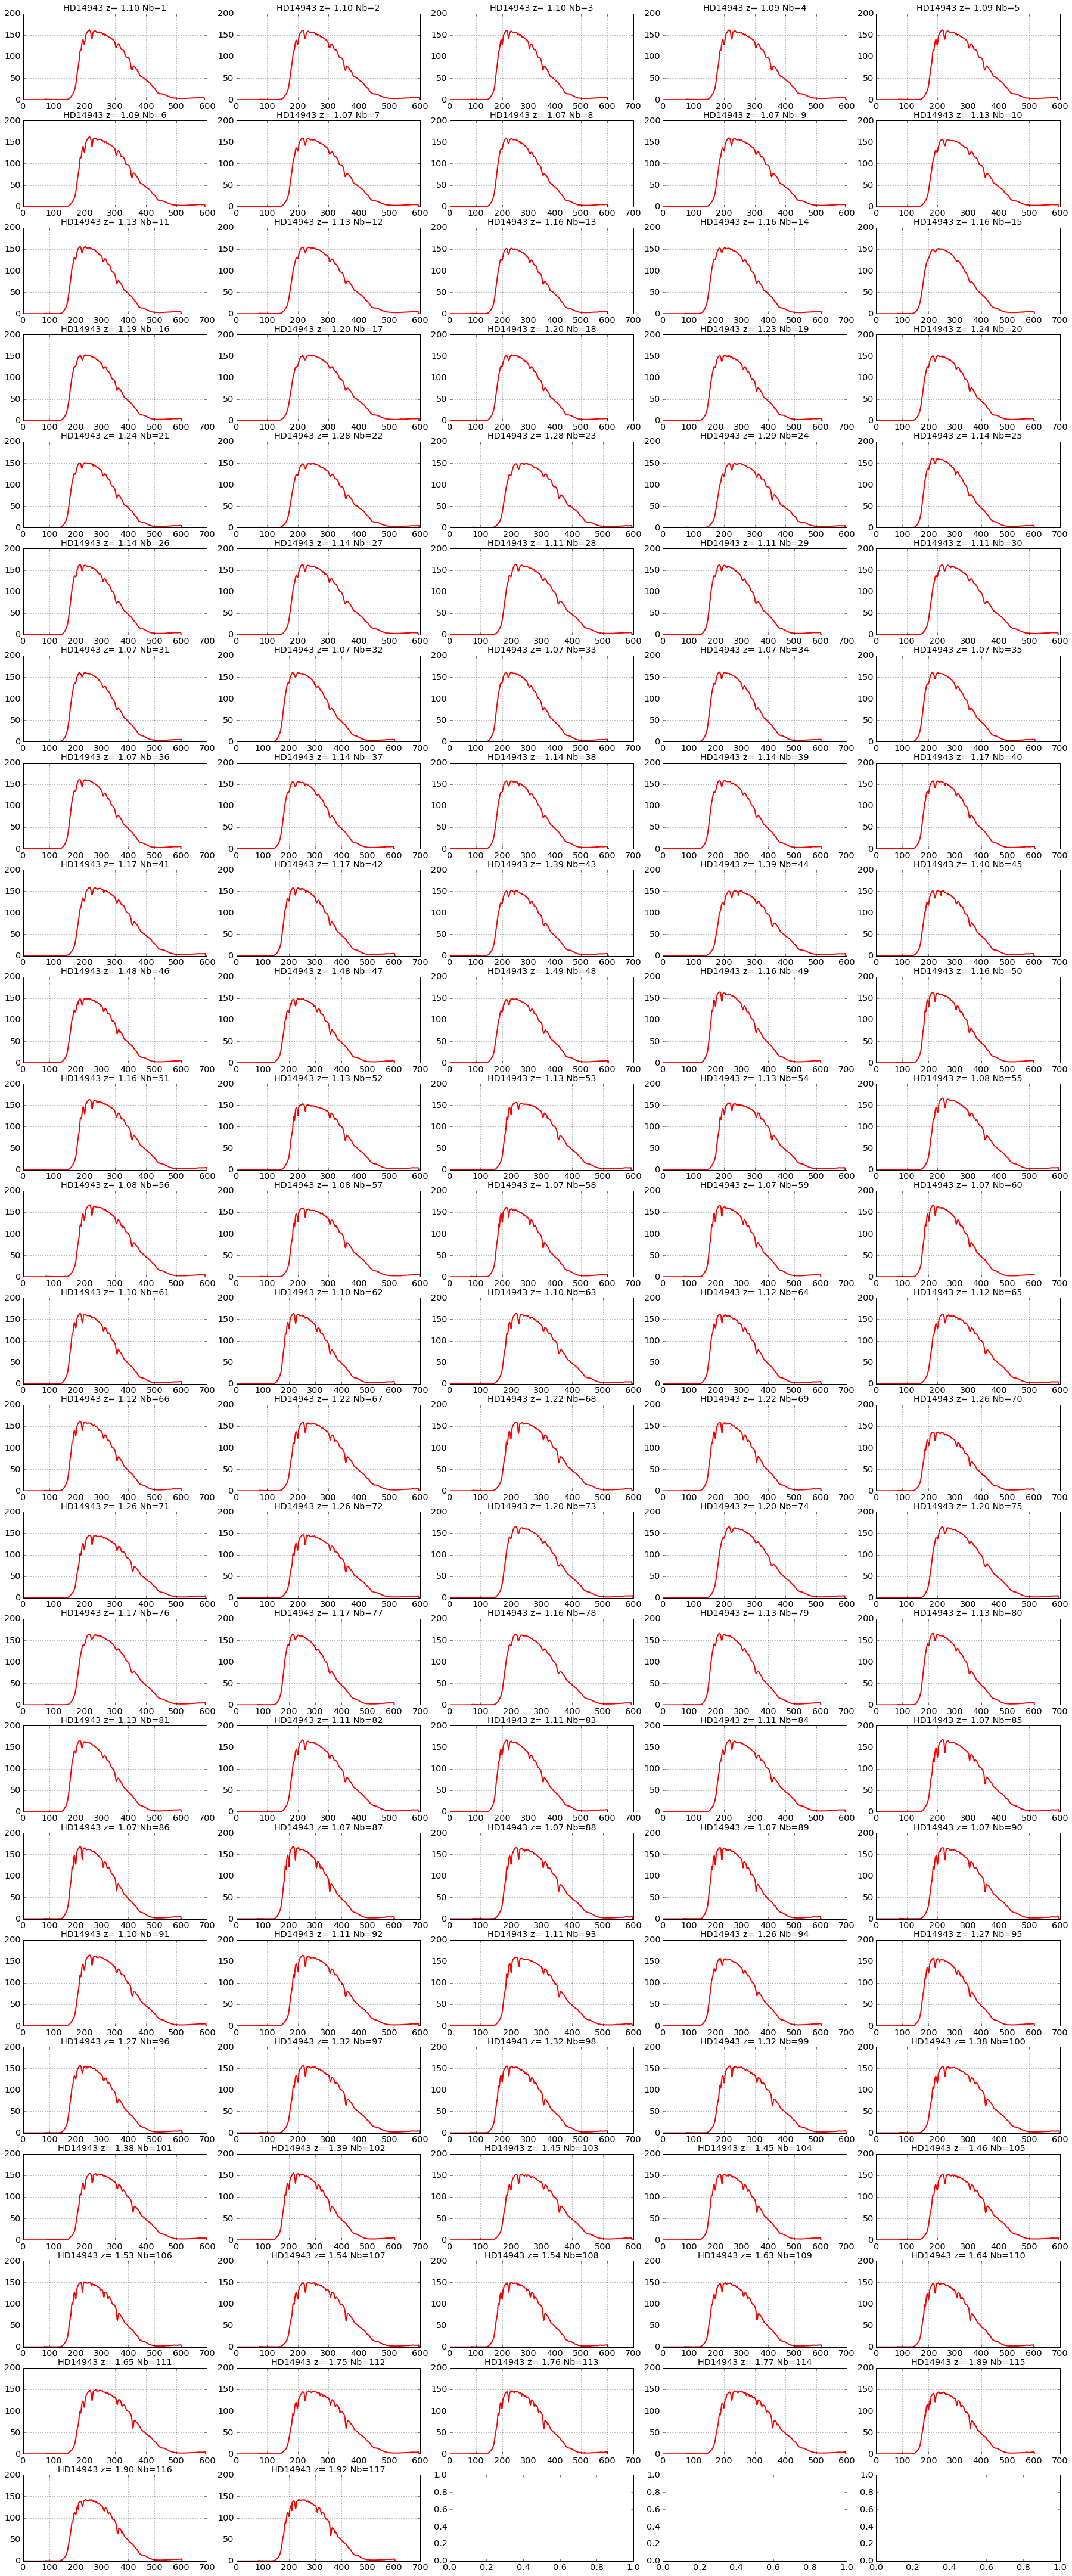

In [71]:
ShowSpectra(all_spectra,all_titles,object_name)

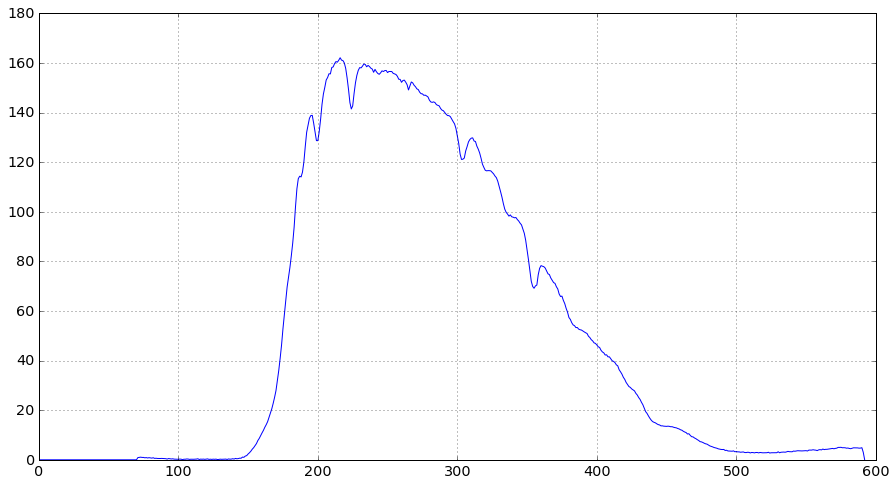

In [62]:
plt.figure(figsize=(15,8))
plt.plot(all_spectra[0])
plt.grid(True)

### prepare outputfilename

In [66]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[2]
    short_partfilename=re.findall('^finalSpectra__(.*)',short_infilename)
    short_outfilename='fittedSpectra_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [67]:
newfullfilenames

['./spectrum_fitsspec/finalSpectra_HD14943_2016_11_23T01_45_51_1.fits',
 './spectrum_fitsspec/finalSpectra_HD14943_2016_11_23T01_46_55_2.fits',
 './spectrum_fitsspec/finalSpectra_HD14943_2016_11_23T01_47_58_3.fits',
 './spectrum_fitsspec/finalSpectra_HD14943_2016_11_23T01_52_42_4.fits',
 './spectrum_fitsspec/finalSpectra_HD14943_2016_11_23T01_54_05_5.fits',
 './spectrum_fitsspec/finalSpectra_HD14943_2016_11_23T01_55_29_6.fits',
 './spectrum_fitsspec/finalSpectra_HD14943_2016_11_23T02_27_22_7.fits',
 './spectrum_fitsspec/finalSpectra_HD14943_2016_11_23T02_28_46_8.fits',
 './spectrum_fitsspec/finalSpectra_HD14943_2016_11_23T02_30_09_9.fits',
 './spectrum_fitsspec/finalSpectra_HD14943_2016_11_23T04_36_28_10.fits',
 './spectrum_fitsspec/finalSpectra_HD14943_2016_11_23T04_37_52_11.fits',
 './spectrum_fitsspec/finalSpectra_HD14943_2016_11_23T04_39_16_12.fits',
 './spectrum_fitsspec/finalSpectra_HD14943_2016_11_23T04_55_21_13.fits',
 './spectrum_fitsspec/finalSpectra_HD14943_2016_11_23T04_56_

### Save outputfilename

In [68]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=spectra_right[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,clobber=True)

In [69]:
!ls

Extract_Spectrum_HD14943.ipynb ViewAllImages_HD1494_v0.ipynb
FindCentralStar_HD14943.ipynb  cut_fitsimages
FindOptRot_HD14943.ipynb       logbk_HD14943_ctioNov2016.fits
MakeLogBook.ipynb              logbk_mucol_ctioNov2016.fits
README.md                      processed_fitsimages
README.md~                     rotated_fitsimages
Test_cython.ipynb              spectrum_fitsimages
ViewAllImages_HD14943.ipynb    spectrum_fitsspec


In [70]:
# !ls -l cut_fitsimages